In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import FileLink
%matplotlib inline

In [2]:
INPUT_DIR = 'E:/anime-recommendation/data'
rating_df = pd.read_csv(INPUT_DIR + '/animelist.csv', 
                            usecols=["user_id", "anime_id", "rating"]
                            #, nrows=90000000
                            )

In [3]:
!ls {INPUT_DIR}


anime.csv
anime_with_synopsis.csv
animelist.csv
html folder
rating_complete.csv
watching_status.csv


In [4]:
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()
len(rating_df)


71418114

In [5]:
# Scaling BTW (0 , 1.0)
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
avg_rating = np.mean(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(rating_df['rating'])

In [6]:
duplicates = rating_df.duplicated()

if duplicates.sum() > 0:
    print('> {} duplicates'.format(duplicates.sum()))
    rating_df = rating_df[~duplicates]

print('> {} duplicates'.format(rating_df.duplicated().sum()))

> 1 duplicates
> 0 duplicates


In [7]:
g = rating_df.groupby('user_id')['rating'].count()
top_users = g.dropna().sort_values(ascending=False)[:20]
top_r = rating_df.join(top_users, rsuffix='_r', how='inner', on='user_id')

g = rating_df.groupby('anime_id')['rating'].count()
top_animes = g.dropna().sort_values(ascending=False)[:20]
top_r = top_r.join(top_animes, rsuffix='_r', how='inner', on='anime_id')

pd.crosstab(top_r.user_id, top_r.anime_id, top_r.rating, aggfunc=np.sum)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9428\1701153738.py:9: FutureWarning: The provided callable <function sum at 0x0000020C593F95A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.crosstab(top_r.user_id, top_r.anime_id, top_r.rating, aggfunc=np.sum)


anime_id,226,1535,1575,2001,2167,4224,5081,5114,6547,6746,9253,9989,10620,11757,15809,16498,19815,20507,22319,30276
user_id,,,,,,,,,,,,,,,,,,,,
20807,1.0,1.0,1.0,1.0,0.8,1.0,0.9,1.0,1.0,1.0,1.0,0.9,1.0,1.0,0.8,1.0,1.0,1.0,1.0,1.0
50485,0.0,0.6,1.0,1.0,0.9,1.0,1.0,1.0,1.0,0.9,1.0,0.9,0.6,1.0,1.0,0.9,1.0,1.0,1.0,0.8
63900,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.8,0.0,0.8,0.8,0.8
68042,0.8,1.0,0.9,1.0,0.7,0.9,1.0,0.9,0.7,0.8,0.9,0.8,0.4,0.4,0.6,0.9,0.3,0.2,0.5,0.9
85472,0.7,0.0,0.0,1.0,0.9,0.9,0.0,0.0,1.0,0.0,0.8,0.0,0.8,0.9,0.8,0.8,0.7,0.7,0.7,0.9
92529,0.9,0.9,1.0,1.0,0.0,0.8,0.0,0.9,0.9,0.0,1.0,0.0,0.8,0.9,0.8,0.9,0.9,0.8,0.8,1.0
122341,0.2,0.3,0.2,0.7,0.4,0.3,0.3,0.8,0.5,0.6,0.7,0.3,0.2,0.1,0.3,0.1,0.4,0.4,0.2,0.6
131988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140590,0.3,0.6,0.5,0.8,0.6,0.8,0.8,0.9,0.5,0.8,0.9,0.7,0.3,0.4,0.6,0.5,0.7,0.7,0.5,0.7


In [8]:
# Encoding categorical data
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

print("Num of users: {}, Num of animes: {}".format(n_users, n_animes))
print("Min rating: {}, Max rating: {}".format(min(rating_df['rating']), max(rating_df['rating'])))

Num of users: 91641, Num of animes: 17560
Min rating: 0.0, Max rating: 1.0


In [9]:
# Shuffle
rating_df = rating_df.sample(frac=1, random_state=73)

X = rating_df[['user', 'anime']].values
y = rating_df["rating"]

In [10]:
# Split
test_set_size = 10000 #10k for test set
train_indices = rating_df.shape[0] - test_set_size 

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 71408113
> Test set ratings: 10000


In [11]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

anime_weights = extract_weights('anime_embedding', my_model)
user_weights = extract_weights('user_embedding', my_model)


NameError: name 'my_model' is not defined

In [13]:
MODEL_PATH = './saved_model/my_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)

In [14]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)


In [15]:
df = pd.read_csv(INPUT_DIR + '/anime.csv', low_memory=True)
df = df.replace("Unknown", np.nan)


In [16]:
# Fixing Names
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print('error')
    
    return name

df['anime_id'] = df['MAL_ID']
df["eng_version"] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))

df.sort_values(by=['Score'], 
               inplace=True,
               ascending=False, 
               kind='quicksort',
               na_position='last')

df = df[["anime_id", "eng_version", 
         "Score", "Genres", "Episodes", 
         "Type", "Premiered", "Members"]]

In [17]:
def getAnimeFrame(anime):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [18]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]
sypnopsis_df = pd.read_csv(INPUT_DIR + '/anime_with_synopsis.csv', usecols=cols)

def getSypnopsis(anime):
    if isinstance(anime, int):
        return sypnopsis_df[sypnopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return sypnopsis_df[sypnopsis_df.Name == anime].sypnopsis.values[0]

In [19]:
#pd.reset_option('all')
pd.set_option("max_colwidth", None)

def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)
        weights = anime_weights
        
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1            
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('animes closest to {}'.format(name))

        if return_dist:
            return dists, closest
        
        rindex = df

        SimilarityArr = []

        for close in closest:
            decoded_id = anime_encoded2anime.get(close)
            sypnopsis = getSypnopsis(decoded_id)
            anime_frame = getAnimeFrame(decoded_id)
            
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name,
                                  "similarity": similarity,"genre": genre,
                                  'sypnopsis': sypnopsis})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except:
        print('{}!, Not Found in Anime list'.format(name))


In [20]:
find_similar_animes('Dragon Ball Z', n=5, neg=False)


animes closest to Dragon Ball Z


,name,similarity,genre,sypnopsis
4,Dragon Ball,0.982987,"Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power","Gokuu Son is a young boy who lives in the woods all alone—that is, until a girl named Bulma runs into him in her search for a set of magical objects called the ""Dragon Balls."" Since the artifacts are said to grant one wish to whoever collects all seven, Bulma hopes to gather them and wish for a perfect boyfriend. Gokuu happens to be in possession of a dragon ball, but unfortunately for Bulma, he refuses to part ways with it, so she makes him a deal: he can tag along on her journey if he lets her borrow the dragon ball's power. With that, the two set off on the journey of a lifetime. They don't go on the journey alone. On the way, they meet the old Muten-Roshi and wannabe disciple Kuririn, with whom Gokuu trains to become a stronger martial artist for the upcoming World Martial Arts Tournament. However, it's not all fun and games; the ability to make any wish come true is a powerful one, and there are others who would do much worse than just wishing for a boyfriend. To stop those who would try to abuse the legendary power, they train to become stronger fighters, using their newfound strength to help the people around them along the way."
3,Dragon Ball GT,0.921395,"Action, Sci-Fi, Adventure, Comedy, Super Power, Magic, Fantasy, Shounen","Emperor Pilaf finally has his hands on the Black Star Dragon Balls after years of searching, which are said to be twice as powerful as Earth's normal ones. Pilaf is about to make his wish for world domination when he is interrupted by Gokuu Son. As a result, Pilaf flubs his wish and accidentally turns Gokuu back into a child. After the wish is granted, the Black Star Dragon Balls scatter across the galaxy. However, Gokuu discovers that they will cause the Earth to explode unless they are all brought back within a year. Uniting with his granddaughter Pan and a young adult Trunks, Gokuu sets off on an adventure through the universe to find the Black Star Dragon Balls and save his planet from destruction."
2,Dragon Ball Z Kai,0.832043,"Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power","Five years after the events of Dragon Ball, martial arts expert Gokuu is now a grown man married to his wife Chi-Chi, with a four-year old son named Gohan. While attending a reunion on Turtle Island with his old friends Master Roshi, Krillin, Bulma and others, the festivities are interrupted when a humanoid alien named Raditz not only reveals the truth behind Gokuu's past, but kidnaps Gohan as well. With Raditz displaying power beyond anything Gokuu has seen before, he is forced to team up with his old nemesis, Piccolo, in order to rescue his son. But when Gokuu and Piccolo reveal the secret of the seven mystical wish-granting Dragon Balls to Raditz, he informs the duo that there is more of his race, the Saiyans, and they won’t pass up an opportunity to seize the power of the Dragon Balls for themselves. These events begin the saga of Dragon Ball Kai , a story that finds Gokuu and his friends and family constantly defending the galaxy from increasingly more powerful threats. Bizarre, comical, heartwarming and threatening characters come together in a series of battles that push the powers and abilities of Gokuu and his friends beyond anything they have ever experienced."
1,Naruto,0.815889,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen","oments prior to Naruto Uzumaki's birth, a huge demon known as the Kyuubi, the Nine-Tailed Fox, attacked Konohagakure, the Hidden Leaf Village, and wreaked havoc. In order to put an end to the Kyuubi's rampage, the leader of the village, the Fourth Hokage, sacrificed his life and sealed the monstrous beast inside the newborn Naruto. Now, Naruto is a hyperactive and knuckle-headed ninja still living in Konohagakure. Shunned because of the Kyuubi inside him, Naruto struggles to find his place in the village, while his burning de

In [21]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, 
                             background_color='white', 
                             colormap='gnuplot').generate_from_frequencies(all_genres)
    
    plt.figure(figsize=(10,8)) 
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def getFavGenre(frame, plot=False):
        frame.dropna(inplace=False)
        all_genres = defaultdict(int)
        
        genres_list = []
        for genres in frame['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre)
                    all_genres[genre.strip()] += 1    
        if plot:
            showWordCloud(all_genres)
        
        return genres_list

    
def get_user_preferences(user_id, plot=False, verbose=0):
    animes_watched_by_user = rating_df[rating_df.user_id==user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)#.head(10)
        .anime_id.values
    )
    
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]
    
    if verbose != 0:
        print("> User #{} has rated {} movies (avg. rating = {:.1f})".format(
          user_id, len(animes_watched_by_user),
          animes_watched_by_user['rating'].mean(),
        ))
    
        print('> preferred genres')
    
    if plot:
        getFavGenre(anime_df_rows, plot)
        
    return anime_df_rows#.eng_version.values


In [22]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
print('> animes highly rated by this user')

pd.DataFrame(user_pref).head(5)


NameError: name 'random_user' is not defined

In [23]:
print('> picking up random user')

ratings_per_user = rating_df.groupby('user_id').size()
random_user = ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0]
print('> user_id:', random_user)


> picking up random user
> user_id: 228037


> User #228037 has rated 186 movies (avg. rating = 0.9)
> preferred genres


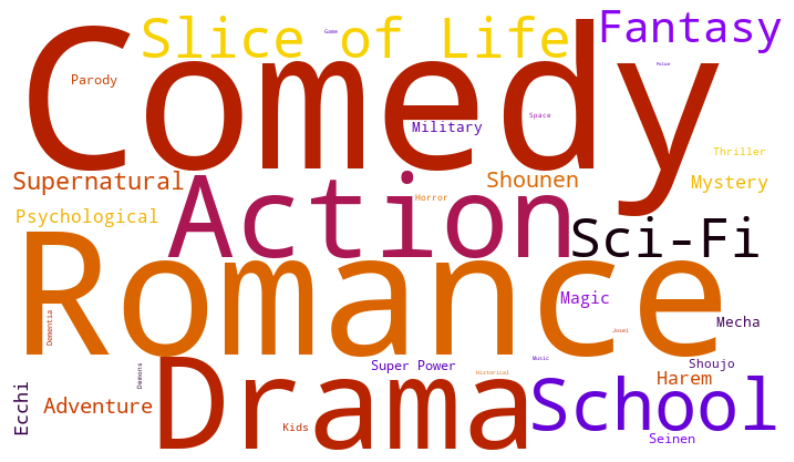

> animes highly rated by this user


,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
5683,Steins;Gate,"Thriller, Sci-Fi"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
3537,Clannad ~After Story~,"Slice of Life, Comedy, Supernatural, Drama, Romance"
2656,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, Mecha"


In [24]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
print('> animes highly rated by this user')

pd.DataFrame(user_pref).head(5)

In [25]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, 
                             background_color='white', 
                             colormap='gnuplot').generate_from_frequencies(all_genres)
    
    plt.figure(figsize=(10,8)) 
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def getFavGenre(frame, plot=False):
        frame.dropna(inplace=False)
        all_genres = defaultdict(int)
        
        genres_list = []
        for genres in frame['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre)
                    all_genres[genre.strip()] += 1    
        if plot:
            showWordCloud(all_genres)
        
        return genres_list

    
def get_user_preferences(user_id, plot=False, verbose=0):
    animes_watched_by_user = rating_df[rating_df.user_id==user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)#.head(10)
        .anime_id.values
    )
    
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]
    
    if verbose != 0:
        print("> User #{} has rated {} movies (avg. rating = {:.1f})".format(
          user_id, len(animes_watched_by_user),
          animes_watched_by_user['rating'].mean(),
        ))
    
        print('> preferred genres')
    
    if plot:
        getFavGenre(anime_df_rows, plot)
        
    return anime_df_rows#.eng_version.values

> User #228037 has rated 186 movies (avg. rating = 0.9)
> preferred genres


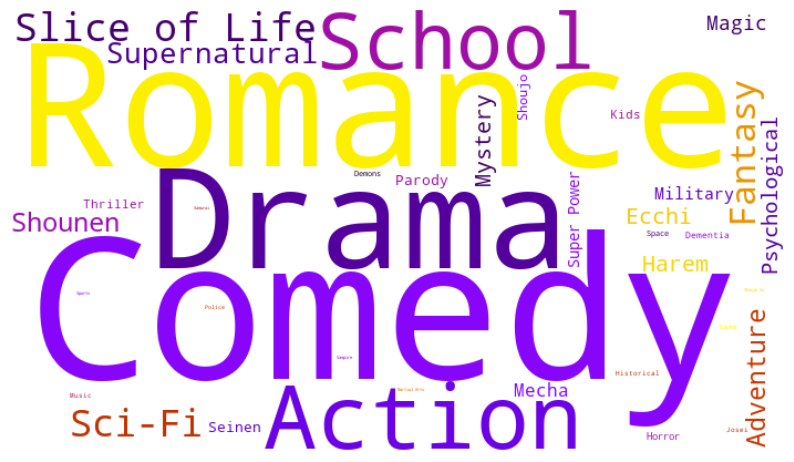

> animes highly rated by this user


,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
5683,Steins;Gate,"Thriller, Sci-Fi"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
3537,Clannad ~After Story~,"Slice of Life, Comedy, Supernatural, Drama, Romance"
2656,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, Mecha"


In [26]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
print('> animes highly rated by this user')

pd.DataFrame(user_pref).head(5)


In [27]:
print("Showing recommendations for user: {}".format(random_user))
print("===" * 25)

animes_watched_by_user = rating_df[rating_df.user_id==random_user]
anime_not_watched_df = df[
    ~df["anime_id"].isin(animes_watched_by_user.anime_id.values)
]

anime_not_watched = list(
    set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys()))
)

anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]

user_encoder = user2user_encoded.get(random_user)

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]]
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = (-ratings).argsort()[:10]

recommended_anime_ids = [
    anime_encoded2anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

Results = []
top_rated_ids = []

for index, anime_id in enumerate(anime_not_watched):
    rating = ratings[index]
    id_ = anime_encoded2anime.get(anime_id[0])
    
    if id_ in recommended_anime_ids:
        top_rated_ids.append(id_)
        try:
            condition = (df.anime_id == id_)
            name = df[condition]['eng_version'].values[0]
            genre = df[condition].Genres.values[0]
            score = df[condition].Score.values[0]
            sypnopsis = getSypnopsis(int(id_))
        except:
            continue
            
        Results.append({#"anime_id": id_, 
                        "name": name, 
                        "pred_rating": rating,
                        "genre": genre, 
                        'sypnopsis': sypnopsis})

print("---" * 25)
print("> Top 10 anime recommendations")
print("---" * 25)


Results = pd.DataFrame(Results).sort_values(by='pred_rating', ascending=False)
Results


Showing recommendations for user: 228037
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
---------------------------------------------------------------------------
> Top 10 anime recommendations
---------------------------------------------------------------------------


,name,pred_rating,genre,sypnopsis
0,Spirited Away,0.943844,"Adventure, Supernatural, Drama","Stubborn, spoiled, and naïve, 10-year-old Chihiro Ogino is less than pleased when she and her parents discover an abandoned amusement park on the way to their new house. Cautiously venturing inside, she realizes that there is more to this place than meets the eye, as strange things begin to happen once dusk falls. Ghostly apparitions and food that turns her parents into pigs are just the start—Chihiro has unwittingly crossed over into the spirit world. Now trapped, she must summon the courage to live and work amongst spirits, with the help of the enigmatic Haku and the cast of unique characters she meets along the way. Vivid and intriguing, Sen to Chihiro no Kamikakushi tells the story of Chihiro's journey through an unfamiliar world as she strives to save her parents and return home."
8,Birdy the Mighty:Decode 02,0.941773,"Action, Sci-Fi, Comedy","Following the Ryunka disaster, Tokyo is left in a period of social turmoil. To make matters worse, the group of aliens directly responsible for the catastrophic event have escaped from the Space Federation and are hiding on Earth. Still sharing a body, Space Federation officer Birdy Cephon Altera, and high schooler, Tsutomu Senkawa, are tasked with capturing the fugitives and bringing them to justice. However, an unexpected crisis develops when the outlaws become targets of an unknown assassin with a vendetta. Now Birdy must deal with the chaos of everyday life and also uncover the identity of the assassin before more escapees fall victim."
4,Final Fantasy VII: Advent Children Complete,0.933811,"Action, Fantasy, Super Power","C: Complete contains a considerable amount of new footage that the original version lacks, as well as roughly a thousand revised scenes. This adds a total of 26 minutes to the film. Some of the new scenes include a more in-depth look at the Geostigma, Denzel and Kadaj's origins, as well as an extended fight between Cloud and Sephiroth. The Japanese release of this edition features a new ending track from Kyosuke Himuro called ""Safe and Sound"", with additional lyrics from My Chemical Romance frontman Gerard Way. The track replaces Himuro's previous track ""Calling"" from the original cut of the film. However, in the North American release, the song ""Calling"" remains, and ""Safe and Sound"" is absent. (Source: Wikipedia)"
2,Slayers Next,0.932923,"Adventure, Comedy, Demons, Magic, Fantasy","In the kingdom of Xoana, Lina Inverse and Gourry Gabriev unexpectedly come across their old companions, Zelgadis Graywords and Princess Ameilia Wil Tesla Saillune. Upon their reunion, the friends end up easily foiling the King of Xoana and his daughter's dastardly plans of world conquest. Soon after, it is revealed that Zelgadis is in search of the world's most valuable magical tome, the Claire Bible, hoping to discover a method to recover his human body among the many secrets sheltered within it. Despite his protests, the rest of the group decides to join in the quest after hearing of his mission. However, just when they were wondering where to start looking for the legendary book, they stumble upon a mysterious priest by the name of Xellos, who claims that he may be of some help in their pursuit."
9,Spice and Wolf II,0.932289,"Adventure, Historical, Romance, Fantasy","Traveling merchant Kraft Lawrence continues his northward journey with wolf goddess Holo, in search of her lost home of Yoitsu. Lawrence and his sharp-witted partner continue to make some small profits along the way, while slowly uncovering more information about Holo's hometown. However, the road to Yoitsu is a bumpy one filled with many troubles—Lawrence runs into a charming young fellow merchant who has his eyes set on the female wolf companion, and he begins to doubt if Holo will remain by his side; he and the goddess will also have to consider precarious and risky business deals as Lawrence strives to achieve hi

In [28]:
print("Showing recommendations for user: {}".format(random_user))
print("===" * 25)

animes_watched_by_user = rating_df[rating_df.user_id==random_user]
anime_not_watched_df = df[
    ~df["anime_id"].isin(animes_watched_by_user.anime_id.values)
]

anime_not_watched = list(
    set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys()))
)

anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]

user_encoder = user2user_encoded.get(random_user)

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]]
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = (-ratings).argsort()[:10]

recommended_anime_ids = [
    anime_encoded2anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

Results = []
top_rated_ids = []

for index, anime_id in enumerate(anime_not_watched):
    rating = ratings[index]
    id_ = anime_encoded2anime.get(anime_id[0])
    
    if id_ in recommended_anime_ids:
        top_rated_ids.append(id_)
        try:
            condition = (df.anime_id == id_)
            name = df[condition]['eng_version'].values[0]
            genre = df[condition].Genres.values[0]
            score = df[condition].Score.values[0]
            sypnopsis = getSypnopsis(int(id_))
        except:
            continue
            
        Results.append({#"anime_id": id_, 
                        "name": name, 
                        "pred_rating": rating,
                        "genre": genre, 
                        'sypnopsis': sypnopsis})

print("---" * 25)
print("> Top 10 anime recommendations")
print("---" * 25)
Results

Showing recommendations for user: 228037
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
---------------------------------------------------------------------------
> Top 10 anime recommendations
---------------------------------------------------------------------------


[{'name': 'Spirited Away',
  'pred_rating': np.float32(0.94384414),
  'genre': 'Adventure, Supernatural, Drama',
  'sypnopsis': "Stubborn, spoiled, and naïve, 10-year-old Chihiro Ogino is less than pleased when she and her parents discover an abandoned amusement park on the way to their new house. Cautiously venturing inside, she realizes that there is more to this place than meets the eye, as strange things begin to happen once dusk falls. Ghostly apparitions and food that turns her parents into pigs are just the start—Chihiro has unwittingly crossed over into the spirit world. Now trapped, she must summon the courage to live and work amongst spirits, with the help of the enigmatic Haku and the cast of unique characters she meets along the way. Vivid and intriguing, Sen to Chihiro no Kamikakushi tells the story of Chihiro's journey through an unfamiliar world as she strives to save her parents and return home."},
 {'name': "Howl's Moving Castle",
  'pred_rating': np.float32(0.9285978)

In [29]:
user_anime_array

[array([59087, 59087, 59087, ..., 59087, 59087, 59087]),
 array([ 3117,  6911,   859, ..., 10657,  9831, 10009])]

In [30]:
user_anime_array

[array([59087, 59087, 59087, ..., 59087, 59087, 59087]),
 array([ 3117,  6911,   859, ..., 10657,  9831, 10009])]

In [31]:
recommended_anime_ids

[199, 5074, 2952, 535, 5341, 3974, 431, 1172, 4106, 3292]

In [32]:
ratings

array([0.21376134, 0.00854581, 0.8776987 , ..., 0.56810284, 0.38475743,
       0.05682476], dtype=float32)

In [33]:
df

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121
...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,ONA,NaN,354
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,TV,NaN,7010
17559,48488,Higurashi:When They Cry – SOTSU,NaN,"Mystery, Dementia, Horror, Psychological, Supernatural, Thriller",NaN,TV,Summer 2021,11309
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,TV,NaN,1386


In [34]:
print("Showing recommendations for user: {}".format('352464'))
print("===" * 25)

animes_watched_by_user = rating_df[rating_df.user_id=='352464']
anime_not_watched_df = df[
    ~df["anime_id"].isin(animes_watched_by_user.anime_id.values)
]

anime_not_watched = list(
    set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys()))
)

anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]

user_encoder = user2user_encoded.get('352464')

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]]
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = (-ratings).argsort()[:10]

recommended_anime_ids = [
    anime_encoded2anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

Results = []
top_rated_ids = []

for index, anime_id in enumerate(anime_not_watched):
    rating = ratings[index]
    id_ = anime_encoded2anime.get(anime_id[0])
    
    if id_ in recommended_anime_ids:
        top_rated_ids.append(id_)
        try:
            condition = (df.anime_id == id_)
            name = df[condition]['eng_version'].values[0]
            genre = df[condition].Genres.values[0]
            score = df[condition].Score.values[0]
            sypnopsis = getSypnopsis(int(id_))
        except:
            continue
            
        Results.append({#"anime_id": id_, 
                        "name": name, 
                        "pred_rating": rating,
                        "genre": genre, 
                        'sypnopsis': sypnopsis})

print("---" * 25)
print("> Top 10 anime recommendations")
print("---" * 25)
Results

Showing recommendations for user: 352464


ValueError: Invalid dtype: object

In [35]:
print("Showing recommendations for user: {}".format('352464'))
print("===" * 25)

animes_watched_by_user = rating_df[rating_df.user_id=='352464']
anime_not_watched_df = df[
    ~df["anime_id"].isin(animes_watched_by_user.anime_id.values)
]

anime_not_watched = list(
    set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys()))
)

anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]

user_encoder = user2user_encoded.get('352464')

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]]

Showing recommendations for user: 352464


In [36]:
user_anime_array

[array([None, None, None, ..., None, None, None], dtype=object),
 array([3117, 559, 6911, ..., 10657, 9831, 10009], dtype=object)]

In [37]:
print("Showing recommendations for user: {}".format(random_user))
print("===" * 25)

animes_watched_by_user = rating_df[rating_df.user_id==random_user]
anime_not_watched_df = df[
    ~df["anime_id"].isin(animes_watched_by_user.anime_id.values)
]

anime_not_watched = list(
    set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys()))
)

anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]

user_encoder = user2user_encoded.get(random_user)

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]]
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = (-ratings).argsort()[:10]

recommended_anime_ids = [
    anime_encoded2anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]


Showing recommendations for user: 228037
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [38]:
recommended_anime_ids

[199, 5074, 2952, 535, 5341, 3974, 431, 1172, 4106, 3292]

In [39]:
random_user

np.int64(228037)

In [40]:
type(random_user)

numpy.int64

In [42]:
temp = np.int64(352464)
print("Showing recommendations for user: {}".format(temp))
print("===" * 25)

animes_watched_by_user = rating_df[rating_df.user_id==temp]
anime_not_watched_df = df[
    ~df["anime_id"].isin(animes_watched_by_user.anime_id.values)
]

anime_not_watched = list(
    set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys()))
)

anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]

user_encoder = user2user_encoded.get(temp)

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]]
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = (-ratings).argsort()[:10]

recommended_anime_ids = [
    anime_encoded2anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

Results = []
top_rated_ids = []

for index, anime_id in enumerate(anime_not_watched):
    rating = ratings[index]
    id_ = anime_encoded2anime.get(anime_id[0])
    
    if id_ in recommended_anime_ids:
        top_rated_ids.append(id_)
        try:
            condition = (df.anime_id == id_)
            name = df[condition]['eng_version'].values[0]
            genre = df[condition].Genres.values[0]
            score = df[condition].Score.values[0]
            sypnopsis = getSypnopsis(int(id_))
        except:
            continue
            
        Results.append({#"anime_id": id_, 
                        "name": name, 
                        "pred_rating": rating,
                        "genre": genre, 
                        'sypnopsis': sypnopsis})

print("---" * 25)
print("> Top 10 anime recommendations")
print("---" * 25)
Results

Showing recommendations for user: 352464
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
---------------------------------------------------------------------------
> Top 10 anime recommendations
---------------------------------------------------------------------------


[{'name': 'Jintian Kaishi Zuo Mingxing 2nd Season',
  'pred_rating': np.float32(0.6213364),
  'genre': 'Music, Slice of Life, Comedy',
  'sypnopsis': 'No synopsis information has been added to this title. Help improve our database by adding a synopsis here .'},
 {'name': 'SD GUNDAM WORLD HEROES',
  'pred_rating': np.float32(0.6794602),
  'genre': nan,
  'sypnopsis': 'The balance of the worlds is maintained by heroes. Suddenly, a red-hot meteor falls upon one of these worlds, called Neo World. An amnesiac youth named Wukong Impulse Gundam appears at the point where it landed. The chaos that starts with this incident spreads through the other worlds, one after another. At the same time, Zhuge Liang Freedom Gundam learns via astrology of an impending disaster. He and his sworn friend Liu Bei Unicorn Gundam take action to save the worlds from this crisis, and begin a journey along with Wukong. What will Wukong Impulse Gundam think as he meets the heroes of each world? Will this youth bring

In [1]:
temp = np.int64(352464)
print("Showing recommendations for user: {}".format(temp))
print("===" * 25)

animes_watched_by_user = rating_df[rating_df.user_id==temp]
anime_not_watched_df = df[
    ~df["anime_id"].isin(animes_watched_by_user.anime_id.values)
]

anime_not_watched = list(
    set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys()))
)

anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]

user_encoder = user2user_encoded.get(temp)

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]]
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = (-ratings).argsort()[:10]

recommended_anime_ids = [
    anime_encoded2anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

Results = []
top_rated_ids = []

for index, anime_id in enumerate(anime_not_watched):
    rating = ratings[index]
    id_ = anime_encoded2anime.get(anime_id[0])
    
    if id_ in recommended_anime_ids:
        top_rated_ids.append(id_)
        try:
            condition = (df.anime_id == id_)
            name = df[condition]['eng_version'].values[0]
            genre = df[condition].Genres.values[0]
            score = df[condition].Score.values[0]
            sypnopsis = getSypnopsis(int(id_))
        except:
            continue
            
        Results.append({#"anime_id": id_, 
                        "name": name, 
                        "pred_rating": rating,
                        "genre": genre, 
                        'sypnopsis': sypnopsis})

print("---" * 25)
print("> Top 10 anime recommendations")
print("---" * 25)
Results

NameError: name 'np' is not defined

In [2]:
from fastapi import FastAPI
import pandas as pd
import tensorflow as tf
import numpy as np

import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

MODEL_PATH = './saved_model/my_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)

app = FastAPI()

INPUT_DIR = 'E:/anime-recommendation/data'
rating_df = pd.read_csv(INPUT_DIR + '/animelist.csv', 
                            usecols=["user_id", "anime_id", "rating"]
                            #, nrows=90000000
                            )
df = pd.read_csv(INPUT_DIR + '/anime.csv', low_memory=True)
df = df.replace("Unknown", np.nan)

n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()

min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
avg_rating = np.mean(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(rating_df['rating'])

duplicates = rating_df.duplicated()

if duplicates.sum() > 0:
    print('> {} duplicates'.format(duplicates.sum()))
    rating_df = rating_df[~duplicates]
    
g = rating_df.groupby('user_id')['rating'].count()
top_users = g.dropna().sort_values(ascending=False)[:20]
top_r = rating_df.join(top_users, rsuffix='_r', how='inner', on='user_id')

g = rating_df.groupby('anime_id')['rating'].count()
top_animes = g.dropna().sort_values(ascending=False)[:20]
top_r = top_r.join(top_animes, rsuffix='_r', how='inner', on='anime_id')

rating_df = rating_df.sample(frac=1, random_state=73)

X = rating_df[['user', 'anime']].values
y = rating_df["rating"]

test_set_size = 10000 #10k for test set
train_indices = rating_df.shape[0] - test_set_size 

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

pd.crosstab(top_r.user_id, top_r.anime_id, top_r.rating, aggfunc=np.sum)

> 1 duplicates


KeyError: "None of [Index(['user', 'anime'], dtype='object')] are in the [columns]"

In [1]:
MODEL_PATH = './saved_model/my_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)

NameError: name 'tf' is not defined

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import FileLink
%matplotlib inline

In [3]:
MODEL_PATH = './saved_model/my_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)

In [4]:
model.validate()

AttributeError: 'Functional' object has no attribute 'validate'

In [1]:
model

NameError: name 'model' is not defined

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import FileLink
%matplotlib inline

In [3]:
INPUT_DIR = 'E:/anime-recommendation/data'
rating_df = pd.read_csv(INPUT_DIR + '/animelist.csv', 
                            usecols=["user_id", "anime_id", "rating"]
                            #, nrows=90000000
                            )

In [4]:

def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print('error')
    
    return name

def getAnimeFrame(anime):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)
        
        weights = extract_weights('anime_embedding', model)
        
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1            
        closest = sorted_dists[-n:]
        
        SimilarityArr = []

        for close in closest:
            decoded_id = anime_encoded2anime.get(close)
            SimilarityArr.append(decoded_id)

        return SimilarityArr

    except Exception as e:
        print(e)
        print('{}!, Not Found in Anime list'.format(name))

def GetAnimesByGenre(df, genre):
    df = df.assign(Genres=df['Genres'].str.split(',')).explode('Genres')
    df['Genres'] = df['Genres'].str.strip()
    
    df_genre = df[df['Genres'] == genre]
    df_sorted = df_genre.sort_values(by='Score', ascending=False)
    
    anime_ids = df_sorted.head(10)[['anime_id', 'Score']]
    print(anime_ids)
    anime_ids['anime_id'] = anime_ids['anime_id'].astype(int)
    print(anime_ids)
    print(type(anime_ids))
    return anime_ids


In [5]:

def find_similar_users(item_input:int, n=10,return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)
        
        weights = extract_weights('user_embedding', model)
    
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('> users similar to #{}'.format(item_input))

        if return_dist:
            return dists, closest
        
        rindex = df
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user_encoded2user.get(close)
                SimilarityArr.append({"similar_users": decoded_id, 
                                      "similarity": similarity})
        print(SimilarityArr)
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", 
                                                        ascending=False)
        
        return Frame
    
    except Exception as e:
        print('find_similar_users')
        print(e)

def get_user_preferences(user_id, plot=False, verbose=0):
    try:    
        animes_watched_by_user = rating_df[rating_df.user_id==int(user_id)]
        user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
        animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
        top_animes_user = (
            animes_watched_by_user.sort_values(by="rating", ascending=False)#.head(10)
            .anime_id.values
        )
        anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
        anime_df_rows = anime_df_rows[["anime_id","eng_version", "Genres"]]
        
        if verbose != 0:
            print("> User #{} has rated {} movies (avg. rating = {:.1f})".format(
            user_id, len(animes_watched_by_user),
            animes_watched_by_user['rating'].mean(),
            ))
        
        
        if plot:
            print('> preferred genres')
            genres_list = getFavGenre(anime_df_rows, plot)
            return anime_df_rows.to_dict(orient="records"), genres_list#.eng_version.values
        
        return anime_df_rows.to_dict(orient="records")
    except Exception as e:
        print("get_user_preferences")
        print(e)

def GetRandomUsers():
    users = []
    for i in range(5):
        ratings_per_user = rating_df.groupby('user_id').size()
        random_user = ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0]
        users.append(int(random_user))
    return users

def find_common_anime(user_recommendations, min_count=3):
    anime_count = defaultdict(int)
    for recommendations in user_recommendations:
        for anime_id in set(recommendations):
            anime_count[anime_id] += 1

    common_anime = [anime_id for anime_id, count in anime_count.items() if count >= min_count]

    return common_anime

def getFavGenre(frame, plot=False):
    try:
        frame.dropna(inplace=False)
        all_genres = defaultdict(int)
        genres_list = []
        for genres in frame['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    if genre.strip() not in genres_list:
                        genres_list.append(genre.strip())
                        all_genres[genre.strip()] += 1    
                        
        return(genres_list)
    
    except Exception as e:
        print("getFavGenre")
        print(e)


In [6]:
MODEL_PATH = './saved_model/my_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)

#global variables initialization

INPUT_DIR = 'E:/anime-recommendation/data'
rating_df = pd.read_csv(INPUT_DIR + '/animelist.csv', 
                            usecols=["user_id", "anime_id", "rating"]
                            #, nrows=90000000
                            )

n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()

min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
avg_rating = np.mean(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

# encoding categorical data start

user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

#encoding categorical data end

df = pd.read_csv(INPUT_DIR + '/anime.csv', low_memory=True)
df = df.replace("Unknown", np.nan)

df['anime_id'] = df['MAL_ID']
df["eng_version"] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))

df = df[["anime_id", "eng_version", "Genres", "Score"]]

print("Server ready... ")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './saved_model/my_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [7]:
MODEL_PATH = '../saved_model/my_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)

#global variables initialization

INPUT_DIR = 'E:/anime-recommendation/data'
rating_df = pd.read_csv(INPUT_DIR + '/animelist.csv', 
                            usecols=["user_id", "anime_id", "rating"]
                            #, nrows=90000000
                            )

n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()

min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
avg_rating = np.mean(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

# encoding categorical data start

user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

#encoding categorical data end

df = pd.read_csv(INPUT_DIR + '/anime.csv', low_memory=True)
df = df.replace("Unknown", np.nan)

df['anime_id'] = df['MAL_ID']
df["eng_version"] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))

df = df[["anime_id", "eng_version", "Genres", "Score"]]

print("Server ready... ")

Server ready... 


In [8]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights


In [9]:

def get_recommendations(user_id, n=500):
    try:
        user_id = np.int64(user_id)
        animes_watched_by_user = rating_df[rating_df.user_id==user_id]
        anime_not_watched_df = df[
            ~df["anime_id"].isin(animes_watched_by_user.anime_id.values)
        ]
        
        anime_not_watched = list(
            set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys()))
        )

        anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]

        user_encoder = user2user_encoded.get(user_id)

        user_anime_array = np.hstack(
            ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
        )

        user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]]
        ratings = model.predict(user_anime_array).flatten()

        top_ratings_indices = (-ratings).argsort()[:int(n)]

        recommended_anime_ids = [
            anime_encoded2anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
        ]
        top_rated_ids = []

        for index, anime_id in enumerate(anime_not_watched):
            id_ = anime_encoded2anime.get(anime_id[0])
            
            if id_ in recommended_anime_ids:
                top_rated_ids.append(id_)
        return top_rated_ids
    
    except Exception as e:
        print(e)

def GetGroupRecommendation(users):
    user_pref = []
    for user in users:
        user_pref.append(get_recommendations(user))
    common_anime_ids = find_common_anime(user_pref, min_count=3)
    return common_anime_ids


In [10]:
anime_ids = GetAnimesByGenre(df, str(genre))

NameError: name 'genre' is not defined

In [11]:
anime_ids = GetAnimesByGenre(df, 'Romance')

       anime_id Score
11308     32281  8.96
3537       4181  8.96
7577      17074  8.78
8883      23273  8.74
16245     40591  8.74
25           44  8.73
14846     38329  8.68
404         431  8.67
4970       7311  8.65
5156       7785  8.61
       anime_id Score
11308     32281  8.96
3537       4181  8.96
7577      17074  8.78
8883      23273  8.74
16245     40591  8.74
25           44  8.73
14846     38329  8.68
404         431  8.67
4970       7311  8.65
5156       7785  8.61
<class 'pandas.core.frame.DataFrame'>


In [12]:
def GetAnimesByGenre(df, genre):
    df = df.assign(Genres=df['Genres'].str.split(',')).explode('Genres')
    df['Genres'] = df['Genres'].str.strip()
    
    df_genre = df[df['Genres'] == genre]
    df_sorted = df_genre.sort_values(by='Score', ascending=False)
    
    anime_ids = df_sorted.head(10)[['anime_id', 'Score']]
    anime_ids['anime_id'] = anime_ids['anime_id'].astype(int)
    return anime_ids

anime_ids = GetAnimesByGenre(df, 'Romance')

In [13]:
def GetAnimesByGenre(df, genre):
    df = df.assign(Genres=df['Genres'].str.split(',')).explode('Genres')
    df['Genres'] = df['Genres'].str.strip()
    
    df_genre = df[df['Genres'] == genre]
    df_sorted = df_genre.sort_values(by='Score', ascending=False)
    
    anime_ids = df_sorted.head(10)[['anime_id', 'Score']]
    anime_ids['anime_id'] = anime_ids['anime_id'].astype(int)
    return anime_ids

anime_ids = GetAnimesByGenre(df, 'Romance')
anime_ids
type(anime_ids)

pandas.core.frame.DataFrame

In [14]:
anime_ids

,anime_id,Score
11308,32281,8.96
3537,4181,8.96
7577,17074,8.78
8883,23273,8.74
16245,40591,8.74
25,44,8.73
14846,38329,8.68
404,431,8.67
4970,7311,8.65
5156,7785,8.61


In [15]:
def GetAnimesByGenre(df, genre):
    df = df.assign(Genres=df['Genres'].str.split(',')).explode('Genres')
    df['Genres'] = df['Genres'].str.strip()
    
    df_genre = df[df['Genres'] == genre]
    df_sorted = df_genre.sort_values(by='Score', ascending=False)
    
    anime_ids = df_sorted.head(10)[['anime_id', 'Score']]
    
    return anime_ids

anime_ids = GetAnimesByGenre(df, 'Romance')

In [16]:
anime_ids['anime_id'].astype(int)

11308    32281
3537      4181
7577     17074
8883     23273
16245    40591
25          44
14846    38329
404        431
4970      7311
5156      7785
Name: anime_id, dtype: int64

In [17]:
anime_ids

,anime_id,Score
11308,32281,8.96
3537,4181,8.96
7577,17074,8.78
8883,23273,8.74
16245,40591,8.74
25,44,8.73
14846,38329,8.68
404,431,8.67
4970,7311,8.65
5156,7785,8.61


In [18]:
type(anime_ids['anime_id'].astype(int))

pandas.core.series.Series

In [19]:
def GetAnimesByGenre(df, genre):
    df = df.assign(Genres=df['Genres'].str.split(',')).explode('Genres')
    df['Genres'] = df['Genres'].str.strip()
    
    df_genre = df[df['Genres'] == genre]
    df_sorted = df_genre.sort_values(by='Score', ascending=False)
    
    # Return the anime_ids as a NumPy array
    anime_ids = df_sorted.head(10)['anime_id'].values
    return anime_ids

# Usage
anime_ids_array = GetAnimesByGenre(df, 'Romance')
print(anime_ids_array)  # e.g., array([123, 456, 789, ...])


[32281  4181 17074 23273 40591    44 38329   431  7311  7785]


In [20]:
type(anime_ids_array)

numpy.ndarray

In [21]:
def GetAnimesByGenre(df, genre):
    df = df.assign(Genres=df['Genres'].str.split(',')).explode('Genres')
    df['Genres'] = df['Genres'].str.strip()
    
    df_genre = df[df['Genres'] == genre]
    df_sorted = df_genre.sort_values(by='Score', ascending=False)
    
    # Return the anime_ids as a NumPy array
    anime_ids = df_sorted.head(10)['anime_id'].values
    return anime_ids

# Usage
anime_ids_array = GetAnimesByGenre(df, 'Romance')
print(anime_ids_array.tolist())  # e.g., array([123, 456, 789, ...])


[32281, 4181, 17074, 23273, 40591, 44, 38329, 431, 7311, 7785]


In [22]:
anime_ids_array = GetAnimesByGenre(df, 'Romance')
print(anime_ids_array.tolist())

[32281, 4181, 17074, 23273, 40591, 44, 38329, 431, 7311, 7785]


In [23]:
def getAnimeFrameByName(anime):
    my_df = df[anime in df.eng_version]
    return my_df

my_df;

NameError: name 'my_df' is not defined

In [24]:
my_df = getAnimeFrameByName(One)

NameError: name 'One' is not defined

In [25]:
my_df = getAnimeFrameByName('One')

KeyError: False

In [26]:
df

,anime_id,eng_version,Genres,Score
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",8.78
1,5,Cowboy Bebop:The Movie,"Action, Drama, Mystery, Sci-Fi, Space",8.39
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",8.24
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",7.27
4,8,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural",6.98
...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,"Adventure, Mystery, Supernatural",NaN
17558,48483,Mieruko-chan,"Comedy, Horror, Supernatural",NaN
17559,48488,Higurashi:When They Cry – SOTSU,"Mystery, Dementia, Horror, Psychological, Supe...",NaN
17560,48491,Yama no Susume: Next Summit,"Adventure, Slice of Life, Comedy",NaN


In [27]:
filtered_df = df[df['eng_version'].str.contains('One', case=False, na=False)]

In [28]:
filtered_df

,anime_id,eng_version,Genres,Score
6,16,Honey and Clover,"Comedy, Drama, Josei, Romance, Slice of Life",8.06
11,21,One Piece,"Action, Adventure, Comedy, Super Power, Drama,...",8.52
129,151,Re: Cutey Honey,"Action, Sci-Fi, Comedy, Ecchi, Shoujo Ai",7.12
141,163,Power Stone,"Adventure, Comedy, Fantasy, Historical, Shounen",6.48
415,443,Onegai☆Teacher: Himitsu na Futari,"Comedy, Ecchi, Romance, Sci-Fi",7.32
...,...,...,...,...
17122,42809,Zone: Intro,"Action, Dementia, Music",NaN
17260,43555,Dr. Stone:Stone Wars Eve of the Battle Special...,"Sci-Fi, Adventure, Shounen",7.13
17278,43682,Koneko no Byouki,"Kids, Music",NaN
17313,43779,Eoneu Nal Jameseo Kkaeeoboni Bagelyeoga Doeeo ...,"Comedy, Romance, Ecchi",6.58


In [29]:
def SearchAnime(name):
    return df[df['eng_version'].str.contains(name, case=False, na=False)]

In [30]:
SearchAnime('One Piece')

,anime_id,eng_version,Genres,Score
11,21,One Piece,"Action, Adventure, Comedy, Super Power, Drama,...",8.52
430,459,One Piece Movie 1,"Action, Adventure, Comedy, Super Power, Fantas...",7.1
431,460,One Piece:Clockwork Island Adventure,"Action, Adventure, Comedy, Super Power, Fantas...",7.17
432,461,One Piece:Chopper Kingdom of Strange Animal Is...,"Action, Adventure, Comedy, Super Power, Fantas...",6.99
433,462,One Piece:Dead End,"Action, Adventure, Comedy, Super Power, Fantas...",7.59
434,463,One Piece:The Curse of the Sacred Sword,"Action, Adventure, Comedy, Super Power, Fantas...",7.23
435,464,One Piece:Baron Omatsuri and the Secret Island,"Adventure, Comedy, Fantasy, Shounen",7.7
436,465,One Piece Movie 7: Karakuri-jou no Mecha Kyohei,"Adventure, Comedy, Fantasy, Shounen",7.28
437,466,One Piece:Defeat the Pirate Ganzack!,"Action, Adventure, Fantasy, Comedy, Super Powe...",6.76
994,1094,One Piece: Umi no Heso no Daibouken-hen,"Action, Adventure, Comedy, Fantasy, Shounen, S...",7.29


In [31]:
SearchAnime('One Piece').head(10)

,anime_id,eng_version,Genres,Score
11,21,One Piece,"Action, Adventure, Comedy, Super Power, Drama,...",8.52
430,459,One Piece Movie 1,"Action, Adventure, Comedy, Super Power, Fantas...",7.1
431,460,One Piece:Clockwork Island Adventure,"Action, Adventure, Comedy, Super Power, Fantas...",7.17
432,461,One Piece:Chopper Kingdom of Strange Animal Is...,"Action, Adventure, Comedy, Super Power, Fantas...",6.99
433,462,One Piece:Dead End,"Action, Adventure, Comedy, Super Power, Fantas...",7.59
434,463,One Piece:The Curse of the Sacred Sword,"Action, Adventure, Comedy, Super Power, Fantas...",7.23
435,464,One Piece:Baron Omatsuri and the Secret Island,"Adventure, Comedy, Fantasy, Shounen",7.7
436,465,One Piece Movie 7: Karakuri-jou no Mecha Kyohei,"Adventure, Comedy, Fantasy, Shounen",7.28
437,466,One Piece:Defeat the Pirate Ganzack!,"Action, Adventure, Fantasy, Comedy, Super Powe...",6.76
994,1094,One Piece: Umi no Heso no Daibouken-hen,"Action, Adventure, Comedy, Fantasy, Shounen, S...",7.29


In [32]:
def SearchAnime(name):
    return df[df['eng_version'].str.contains(name, case=False, na=False)].head(10)

In [33]:
SearchAnime('Naruto')

,anime_id,eng_version,Genres,Score
10,20,Naruto,"Action, Adventure, Comedy, Super Power, Martia...",7.91
414,442,Naruto the Movie:Ninja Clash in the Land of Snow,"Adventure, Comedy, Historical, Supernatural, D...",7.1
557,594,Naruto:The Lost Story - Mission:Protect the Wa...,"Action, Adventure, Comedy, Shounen, Super Power",6.76
696,761,Naruto:Find the Crimson Four-leaf Clover!,"Adventure, Comedy, Shounen",6.52
848,936,Naruto the Movie 2:Legend of the Stone of Gelel,"Adventure, Comedy, Drama, Fantasy, Shounen, Su...",6.88
975,1074,Naruto Narutimate Hero 3: Tsuini Gekitotsu! Jo...,"Game, Adventure, Comedy, Shounen",6.77
1574,1735,Naruto:Shippuden,"Action, Adventure, Comedy, Super Power, Martia...",8.16
1963,2144,Naruto the Movie 3:Guardians of the Crescent M...,"Action, Adventure",6.89
2267,2472,Naruto:Shippuden the Movie,"Action, Adventure, Comedy, Fantasy, Shounen",7.29
3516,4134,Naruto Shippuden:Konoha Gakuen - Special,Comedy,7.15


In [34]:
def SearchAnime(name):
    return df['anime_id][df['eng_version'].str.contains(name, case=False, na=False)].head(10)

SyntaxError: unterminated string literal (detected at line 2) (1308505533.py, line 2)

In [35]:
def SearchAnime(name):
    return df[df['eng_version'].str.contains(name, case=False, na=False)]['anime_id].head(10)

SyntaxError: unterminated string literal (detected at line 2) (2010045158.py, line 2)

In [36]:
def SearchAnime(name):
    return df[df['eng_version'].str.contains(name, case=False, na=False)]['anime_id'].head(10)

In [37]:
SearchAnime('Naruto')

10        20
414      442
557      594
696      761
848      936
975     1074
1574    1735
1963    2144
2267    2472
3516    4134
Name: anime_id, dtype: int64

In [38]:
SearchAnime('Naruto').to_dict(orient="records")

TypeError: Series.to_dict() got an unexpected keyword argument 'orient'

In [39]:
type(SearchAnime('Naruto'))

pandas.core.series.Series

In [40]:
df[df['eng_version'].str.contains('One', case=False, na=False)]['anime_id'].head(10)

6       16
11      21
129    151
141    163
415    443
430    459
431    460
432    461
433    462
434    463
Name: anime_id, dtype: int64

In [41]:
SearchAnime('Naruto').tolist()

[20, 442, 594, 761, 936, 1074, 1735, 2144, 2472, 4134]

In [42]:
df[df['eng_version'].str.contains('One', case=False, na=False)]['anime_id'].head(10)

6       16
11      21
129    151
141    163
415    443
430    459
431    460
432    461
433    462
434    463
Name: anime_id, dtype: int64

In [43]:
df[df['eng_version'].str.contains('one', case=False, na=False)]['anime_id'].head(10)

6       16
11      21
129    151
141    163
415    443
430    459
431    460
432    461
433    462
434    463
Name: anime_id, dtype: int64